In [1]:
## DeepExplain - Keras (TF backend) example
### MNIST with CNN

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tempfile, sys, os
sys.path.insert(0, os.path.abspath('..'))

import keras
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

# Import DeepExplain
from deepexplain.tensorflow import DeepExplain

Using TensorFlow backend.


In [3]:
# Build and train a network.

batch_size = 10#128
num_classes = 10
epochs = 3

# input image dimensions
img_rows, img_cols = 28, 28

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data() #small example
x_train = x_train[:600]
y_train = y_train[:600]

x_test = x_test[:100]
y_test = y_test[:100]



if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
x_train = (x_train - 0.5) * 2
x_test = (x_test - 0.5) * 2
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax')) 
# ^ IMPORTANT: notice that the final softmax must be in its own layer 
# if we want to target pre-softmax units

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

x_train shape: (600, 28, 28, 1)
600 train samples
100 test samples
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Train on 600 samples, validate on 100 samples
Epoch 1/3
600/600 [==============================] - 2s 4ms/step - loss: 1.4535 - accuracy: 0.5433 - val_loss: 0.6130 - val_accuracy: 0.8300
Epoch 2/3
600/600 [==============================] - 1s 2ms/step - loss: 0.5232 - accuracy: 0.8250 - val_loss: 0.3504 - val_accuracy: 0.8800
Epoch 3/3
600/600 [==============================] - 1s 2ms/step - loss: 0.3113 - accuracy: 0.9000 - val_loss: 0.2224 - val_accuracy: 0.9200
Test loss: 0.22239090681076049
Test accuracy: 0.9200000166893005


In [4]:
%%time
with DeepExplain(session=K.get_session()) as de:  # <-- init DeepExplain context
    # Need to reconstruct the graph in DeepExplain context, using the same weights.
    # With Keras this is very easy:
    # 1. Get the input tensor to the original model
    input_tensor = model.layers[0].input
    
    # 2. We now target the output of the last dense layer (pre-softmax)
    # To do so, create a new model sharing the same layers untill the last dense (index -2)
    fModel = Model(inputs=input_tensor, outputs = model.layers[-2].output)
    target_tensor = fModel(input_tensor)
    
    xs = x_test[0:10]
    ys = y_test[0:10]
    
    #attributions_gradin = de.explain('grad*input', target_tensor, input_tensor, xs, ys=ys)
    #attributions_sal   = de.explain('saliency', target_tensor, input_tensor, xs, ys=ys)
    #attributions_ig    = de.explain('intgrad', target_tensor, input_tensor, xs, ys=ys)
    #attributions_dl    = de.explain('deeplift', target_tensor, input_tensor, xs, ys=ys)
    attributions_idl   = de.explain('integdeeplift', target_tensor, input_tensor, xs, ys=ys)
    #attributions_elrp  = de.explain('elrp', target_tensor, input_tensor, xs, ys=ys)
    #attributions_occ   = de.explain('occlusion', target_tensor, input_tensor, xs, ys=ys)
    
    # Compare Gradient * Input with approximate Shapley Values
    # Note1: Shapley Value sampling with 100 samples per feature (78400 runs) takes a couple of minutes on a GPU.
    # Note2: 100 samples are not enough for convergence, the result might be affected by sampling variance
    # attributions_sv     = de.explain('shapley_sampling', target_tensor, input_tensor, xs, ys=ys, samples=100)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


CPU times: user 10.6 s, sys: 21.3 s, total: 32 s
Wall time: 2.41 s


/Users/jsu/opt/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:23: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '


CPU times: user 853 ms, sys: 87.5 ms, total: 940 ms
Wall time: 408 ms


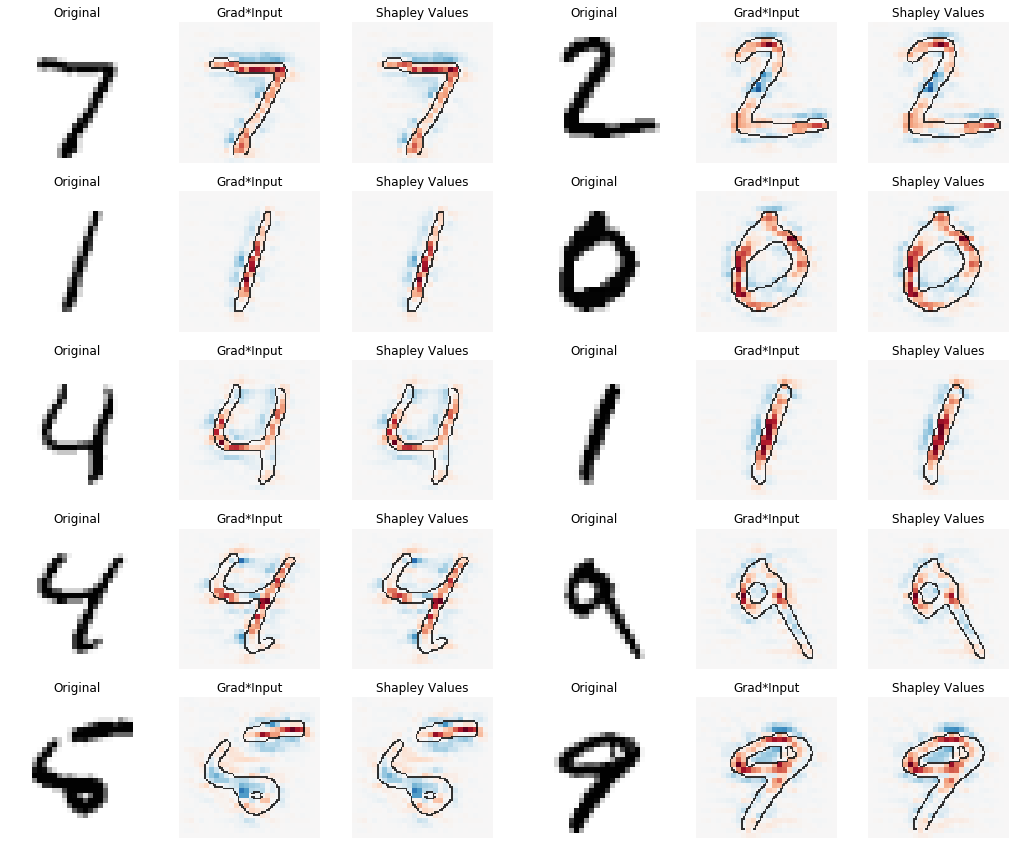

In [6]:
%%time
from utils import plot, plt
%matplotlib inline

n_cols = 6
n_rows = int(len(attributions_idl) / 2)
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(3*n_cols, 3*n_rows))

for i, (a1, a2) in enumerate(zip(attributions_idl, attributions_idl)):
    row, col = divmod(i, 2)
    plot(xs[i].reshape(28, 28), cmap='Greys', axis=axes[row, col*3]).set_title('Original')
    plot(a1.reshape(28,28), xi = xs[i], axis=axes[row,col*3+1]).set_title('Grad*Input')
    plot(a2.reshape(28,28), xi = xs[i], axis=axes[row,col*3+2]).set_title('Shapley Values')

## Batch processing
In this example, we generate explanations for the entire testset (10000 images) using the fast Gradient*Input method.
`DeepExplain.explain()` accepts the `batch_size` parameter if the data to process does not fit in memory.

In [ ]:
%%time
with DeepExplain(session=K.get_session()) as de:  # <-- init DeepExplain context
    # Need to reconstruct the graph in DeepExplain context, using the same weights.
    # With Keras this is very easy:
    # 1. Get the input tensor to the original model
    input_tensor = model.layers[0].input
    
    # 2. We now target the output of the last dense layer (pre-softmax)
    # To do so, create a new model sharing the same layers untill the last dense (index -2)
    fModel = Model(inputs=input_tensor, outputs = model.layers[-2].output)
    target_tensor = fModel(input_tensor)
    
    xs = x_test
    ys = y_test
    
    attributions_gradin = de.explain('grad*input', target_tensor, input_tensor, xs, ys=ys, batch_size=128)
    print ("Done")